In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
ratings = pd.read_csv("rating.csv")
tags = pd.read_csv("tag.csv")
movies = pd.read_csv("movie.csv")

In [3]:
print(ratings.shape)
print(tags.shape)
print(movies.shape)

(20000263, 4)
(465564, 4)
(27278, 3)


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.drop('timestamp',axis=1,inplace=True)
tags.drop('timestamp',axis=1,inplace=True)

In [8]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.head(20)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action Crime Thriller
6,7,Sabrina (1995),Comedy Romance
7,8,Tom and Huck (1995),Adventure Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action Adventure Thriller


In [9]:
movies['movieId'].nunique()

27278

In [10]:
ratings['movieId'].nunique()

26744

In [11]:
# Data cleaning
# Only keeping users who have rated more than 55 movies
ratings_new = ratings.groupby('userId').filter(lambda x:len(x)>=55)
ratings_new.shape

(18062883, 3)

In [12]:
(ratings_new['movieId'].nunique()/ratings['movieId'].nunique())*100

99.81304217768472

In [13]:
(ratings_new['userId'].nunique()/ratings['userId'].nunique())*100

57.797867040211415

In [14]:
# 99 percent of original movies kept
# 61 percent of original users kept

In [15]:
movie_list = ratings_new['movieId'].unique().tolist()
len(movie_list)

26694

In [16]:
# Only keeping movies from dataframe in which users have rated more than 50 movies
print('Original: ',movies.shape)
movies = movies[movies['movieId'].isin(movie_list)]
print('Modified: ',movies.shape)

Original:  (27278, 3)
Modified:  (26694, 3)


In [17]:
map_movies_id = dict(zip(movies['title'].tolist(),movies['movieId'].tolist()))
map_movies_id

{'Toy Story (1995)': 1,
 'Jumanji (1995)': 2,
 'Grumpier Old Men (1995)': 3,
 'Waiting to Exhale (1995)': 4,
 'Father of the Bride Part II (1995)': 5,
 'Heat (1995)': 6,
 'Sabrina (1995)': 7,
 'Tom and Huck (1995)': 8,
 'Sudden Death (1995)': 9,
 'GoldenEye (1995)': 10,
 'American President, The (1995)': 11,
 'Dracula: Dead and Loving It (1995)': 12,
 'Balto (1995)': 13,
 'Nixon (1995)': 14,
 'Cutthroat Island (1995)': 15,
 'Casino (1995)': 16,
 'Sense and Sensibility (1995)': 17,
 'Four Rooms (1995)': 18,
 'Ace Ventura: When Nature Calls (1995)': 19,
 'Money Train (1995)': 20,
 'Get Shorty (1995)': 21,
 'Copycat (1995)': 22,
 'Assassins (1995)': 23,
 'Powder (1995)': 24,
 'Leaving Las Vegas (1995)': 25,
 'Othello (1995)': 26,
 'Now and Then (1995)': 27,
 'Persuasion (1995)': 28,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 29,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 30,
 'Dangerous Minds (1995)': 31,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)':

In [18]:
combined = pd.merge(movies,tags,on='movieId',how='left')
combined.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,TÃ©a Leoni does not star in this movie


In [19]:
combined.isnull().sum()

movieId       0
title         0
genres        0
userId     7690
tag        7706
dtype: int64

In [20]:
combined.fillna('',inplace=True)
combined.isnull().sum()

movieId    0
title      0
genres     0
userId     0
tag        0
dtype: int64

In [21]:
combined = pd.DataFrame(combined.groupby('movieId')['tag'].apply(lambda x : '%s' % ' '.join(x)))
combined.head()

,tag
movieId,
1,Watched computer animation Disney animated fea...
2,time travel adapted from:book board game child...
3,old people that is actually funny sequel fever...
4,chick flick revenge characters chick flick cha...
5,Diane Keaton family sequel Steve Martin weddin...


In [22]:
combined_new = pd.merge(movies,combined,on='movieId',how='left')
combined_new.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...


In [23]:
combined_new['data'] = combined_new[['tag','genres']].apply(lambda x : ' '.join(x),axis=1)
combined_new

,movieId,title,genres,tag,data
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters chick flick cha...,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...,Diane Keaton family sequel Steve Martin weddin...
...,...,...,...,...,...
26689,131254,Kein Bund für's Leben (2007),Comedy,,Comedy
26690,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,,Comedy
26691,131258,The Pirates (2014),Adventure,bandits Korea mutiny pirates whale,bandits Korea mutiny pirates whale Adventure
26692,131260,Rentun Ruusu (2001),(no genres listed),,(no genres listed)


In [24]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(combined_new['data'])
tfidf_data = pd.DataFrame(tfidf_matrix.toarray(),index=combined_new.index.tolist())
tfidf_data

,0,1,2,3,4,5,6,7,8,9,...,23694,23695,23696,23697,23698,23699,23700,23701,23702,23703
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


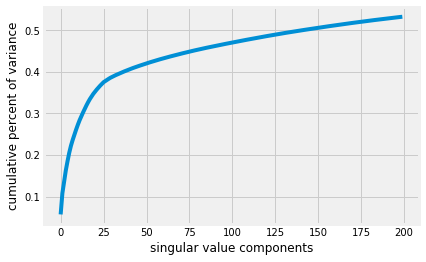

In [25]:
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_data)

explained = svd.explained_variance_ratio_.cumsum()
plt.xlabel('singular value components')
plt.ylabel('cumulative percent of variance')
plt.plot(explained);

In [26]:
latent_matrix_df = pd.DataFrame(latent_matrix[:,0:200],index = combined_new['title'].tolist())
latent_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.026804,0.052404,0.019479,0.003361,0.004004,-0.024907,0.115090,0.012749,-0.001627,0.103939,...,-0.120515,-0.016684,0.033833,-0.059539,-0.086258,-0.015988,0.003483,0.074889,-0.148353,0.055124
Jumanji (1995),0.010512,0.010537,0.025846,0.000882,0.013254,-0.001140,0.068154,0.012675,0.006184,0.050531,...,0.013490,-0.021739,-0.042182,-0.019742,0.048058,0.018407,0.003975,-0.021569,-0.019751,-0.044163
Grumpier Old Men (1995),0.038827,0.073948,-0.004930,-0.001323,0.031760,0.002476,-0.003612,-0.001630,-0.000253,0.000645,...,0.007968,0.005508,-0.021540,0.007423,-0.017238,-0.022054,-0.006201,-0.023318,0.011860,-0.012769
Waiting to Exhale (1995),0.136327,0.077169,-0.020606,-0.002103,0.101073,0.012071,-0.012106,-0.002062,-0.004896,-0.002583,...,0.091790,-0.040208,-0.055462,-0.032898,0.056000,0.031569,0.095713,-0.024852,-0.061883,-0.016711
Father of the Bride Part II (1995),0.038644,0.084084,0.000456,0.000029,-0.013619,0.000075,0.013469,-0.000218,0.008462,0.013971,...,-0.015299,0.007476,0.010809,-0.003223,-0.004944,-0.035443,-0.005950,0.002981,0.007030,0.020138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kein Bund für's Leben (2007),0.383834,0.889127,-0.089173,-0.019586,-0.217577,0.002209,-0.033704,-0.043409,-0.016034,-0.009939,...,-0.000025,-0.000726,-0.000179,0.000255,-0.000188,0.000167,-0.000399,0.000087,0.000025,0.000125
"Feuer, Eis & Dosenbier (2002)",0.383834,0.889127,-0.089173,-0.019586,-0.217577,0.002209,-0.033704,-0.043409,-0.016034,-0.009939,...,-0.000025,-0.000726,-0.000179,0.000255,-0.000188,0.000167,-0.000399,0.000087,0.000025,0.000125
The Pirates (2014),0.006151,0.003922,0.014204,0.001669,0.012996,-0.021347,0.058406,-0.000141,-0.001525,0.015742,...,-0.000073,0.001171,0.005957,-0.010991,-0.008726,0.005117,0.002289,-0.007406,-0.001221,-0.005560
Rentun Ruusu (2001),0.000028,0.000019,0.000157,0.000417,0.000186,0.000027,0.000401,-0.000411,0.004754,0.000053,...,-0.000433,0.000196,0.000180,-0.000238,-0.000587,0.000418,0.000250,0.000542,-0.000319,0.000197


In [27]:
ratings_new

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000260,138493,69644,3.0
20000261,138493,70286,5.0


In [28]:
ratings_f1 = pd.merge(movies[['movieId']],ratings_new,on='movieId',how='right')
ratings_f2 = ratings_f1.pivot(index='movieId',columns='userId',values='rating').fillna(0)

In [29]:
ratings_f2.shape

(26694, 80046)

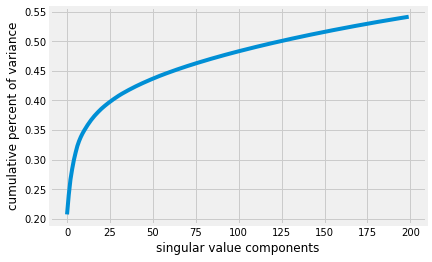

In [30]:
latent_matrix_new = svd.fit_transform(ratings_f2)
latent_matrix_2 = pd.DataFrame(latent_matrix_new,index=combined_new['title'].tolist())

explained = svd.explained_variance_ratio_.cumsum()
plt.xlabel('singular value components')
plt.ylabel('cumulative percent of variance')
plt.plot(explained);

In [33]:
movie_1 = np.array(latent_matrix_df.loc['Mask, The (1994)']).reshape(1,-1)
movie_2 = np.array(latent_matrix_2.loc['Mask, The (1994)']).reshape(1,-1)

score_1 = cosine_similarity(latent_matrix_df,movie_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2,movie_2).reshape(-1)

hybrid = ((score_1+score_2)/2.0)

dictDf = {'content':score_1,'collaborative':score_2,'hybrid':hybrid}
similar = pd.DataFrame(dictDf, index=latent_matrix_df.index)

similar.sort_values('hybrid',ascending=False,inplace=True)
similar.head(10)

,content,collaborative,hybrid
"Mask, The (1994)",1.000000,1.000000,1.000000
Ace Ventura: Pet Detective (1994),0.964230,0.865913,0.915071
Ace Ventura: When Nature Calls (1995),0.927181,0.792279,0.859730
Dumb & Dumber (Dumb and Dumber) (1994),0.810980,0.846650,0.828815
Liar Liar (1997),0.911777,0.689555,0.800666
Batman Forever (1995),0.729036,0.794536,0.761786
"Me, Myself & Irene (2000)",0.951318,0.492081,0.721700
"Cable Guy, The (1996)",0.809440,0.626546,0.717993
Bruce Almighty (2003),0.821785,0.512476,0.667130
Man on the Moon (1999),0.795512,0.464119,0.629816
